# RF_Track interface

In [1]:
%matplotlib widget

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import xtrack as xt
import xobjects as xo
import xpart as xp

import RF_Track as RFT

#### Define the RF-Track Volume with constant magnetic field

In [3]:
# Bend parameters
clight = 299792458 # m/s
p0c = 1.2e9  # eV
lbend = 3 # m
angle = np.pi / 2 # rad
rho = lbend / angle # m
By = p0c / rho / clight # T

vol = RFT.Volume()
vol.dt_mm = 0.1
vol.odeint_algorithm = 'rk2'
vol.set_static_Bfield(0.0, By, 0.0)
vol.set_s0(rho, 0.0, 0.0, 0.0, 0.0, 0.0)
vol.set_s1(0.0, 0.0, rho, 0.0, 0.0, -angle)
vol.set_length(lbend)

### Use RF-Track volume to model the bends in a small ring

In [4]:
elements = {
    'd1.1':  xt.Drift(length=1),
    'mb1.1': xt.RFT_Element(element=vol),
    'd2.1':  xt.Drift(length=1),

    'mqd.1': xt.Quadrupole(length=0.3, k1=-0.7),
    'd3.1':  xt.Drift(length=1),
    'mb2.1': xt.RFT_Element(element=vol),
    'd4.1':  xt.Drift(length=1),

    'd1.2':  xt.Drift(length=1),
    'mb1.2': xt.RFT_Element(element=vol),
    'd2.2':  xt.Drift(length=1),

    'mqd.2': xt.Quadrupole(length=0.3, k1=-0.7),
    'd3.2':  xt.Drift(length=1),
    'mb2.2': xt.RFT_Element(element=vol),
    'd4.2':  xt.Drift(length=1),
}

line = xt.Line(elements=elements, element_names=list(elements.keys()))
line.particle_ref = xt.Particles(p0c=p0c, mass0=xt.PROTON_MASS_EV)
line.build_tracker()

Found suitable prebuilt kernel `default_only_xtrack`.


#### Generate a simple particle distribution

In [9]:
n_part = 200
rng = np.random.default_rng(2021)
particles = xp.Particles(p0c=p0c, #eV
                        q0=1, mass0=xp.PROTON_MASS_EV,
                        x=rng.uniform(-1e-3, 1e-3, n_part),
                        px=rng.uniform(-1e-5, 1e-5, n_part),
                        y=rng.uniform(-2e-3, 2e-3, n_part),
                        py=rng.uniform(-3e-5, 3e-5, n_part),
                        zeta=rng.uniform(-1e-2, 1e-2, n_part),
                        delta=rng.uniform(-1e-3, 1e-3, n_part))

### Track

In [10]:
line.track(particles)

#### Compare against standard Xsuite tracking

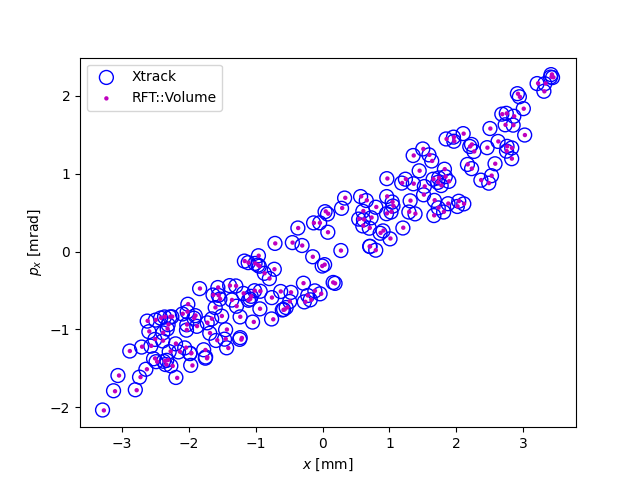

In [12]:
from scipy.io import savemat, loadmat
V = np.transpose(np.array([particles.x, particles.px, particles.y, particles.py, particles.zeta, particles.delta]))
xt = loadmat('../../xtrack/examples/rf_track/particles_xt.mat')
X = xt['x']

plt.figure()
plt.scatter(X[:,0]*1e3, X[:,1]*1e3, label='Xsuite',      s=100, facecolors='none', edgecolors='b')
plt.scatter(V[:,0]*1e3, V[:,1]*1e3, label='RFT::Volume', s=10, facecolors='m', edgecolors='none')
plt.xlabel("$x$ [mm]")
plt.ylabel("$p_x$ [mrad]")
plt.legend()